In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 15 - The SIMPLE model of memory

## 15.1 The SIMPLE model
Brown, Neath, and Chater (2007) proposed the SIMPLE (Scale-Invariant Memory, Perception, and LEarning) model, which, among various applications, has been applied to the basic memory phenomenon of free recall.

$$ c_x \sim \text{Uniform}(0,100)$$
$$ s_x \sim \text{Uniform}(0,100)$$
$$ t_x \sim \text{Uniform}(0,1) $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

In [2]:
y = pd.read_csv("data/k_M.txt","\,",header=None)
n = np.array([1440, 1280, 1520, 1520, 1200, 1280])
listlength = np.array([10, 15, 20, 20, 30, 40])
lagall = np.array([2,2,2,1,1,1])
offset = np.array([15,20,25,10,15,20])
dsets = 6
m = np.zeros(np.shape(y))
for i in range(dsets):
    m[i,0:listlength[i]]=offset[i]+np.arange((listlength[i])*lagall[i],0,-lagall[i])
ymat = np.asarray(y).T
mmat = m.T
pc = pd.read_csv("data/pc_M.txt", "\,",header=None)
pcmat = np.asarray(pc).T

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


Applied interval-transform to cx and added transformed cx_interval to model.
Applied interval-transform to sx and added transformed sx_interval to model.
Applied interval-transform to tx and added transformed tx_interval to model.
 [-----------------100%-----------------] 300000 of 300000 complete in 434.2 sec

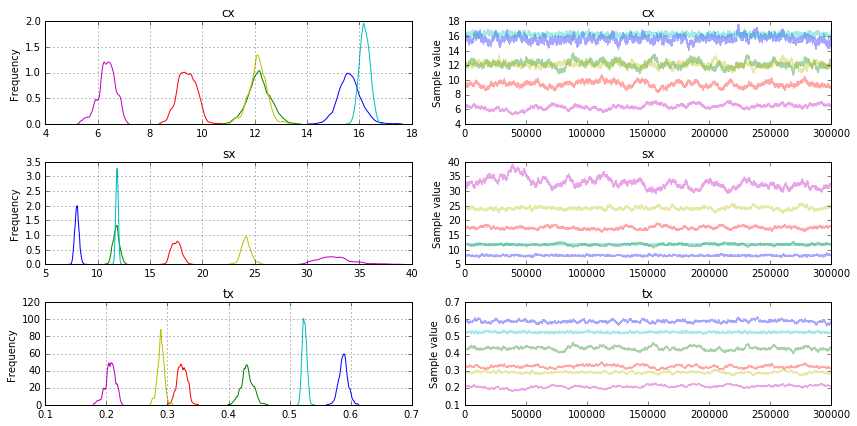

In [6]:
with pm.Model() as simple1:
    # This model is also sens
    cx = pm.Uniform("cx",lower=0,upper=100,shape=dsets,testval=np.ones(dsets)*20)
    sx = pm.Uniform("sx",lower=0,upper=100,shape=dsets)
    tx = pm.Uniform("tx",lower=0,upper=1,shape=dsets)
    
    yobs=[]
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz,x],]*sz).T
        m2 = np.array([mmat[0:sz,x],]*sz)

        eta=T.exp(-cx[x]*abs(T.log(m1)-T.log(m2)))
        etasum=T.reshape(T.repeat(T.sum(eta,axis=1),sz),(sz,sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+T.exp(-sx[x]*(disc-tx[x])))
        # Free Recall Overall Response Probability
        theta = T.clip(T.sum(resp,axis=1),0,.999)
        # theta=1-T.prod(1-resp,axis=1)
        
        yobs.append([pm.Binomial("yobs_%x"%x,p=theta, n=n[x],observed=ymat[0:sz,x])])
        
    start = pm.find_MAP()
    # step = pm.NUTS(scaling=start)
    trace = pm.sample(3e5,start=start,step=pm.Metropolis())
    
pm.traceplot(trace,varnames=['cx','sx','tx'])
plt.show()

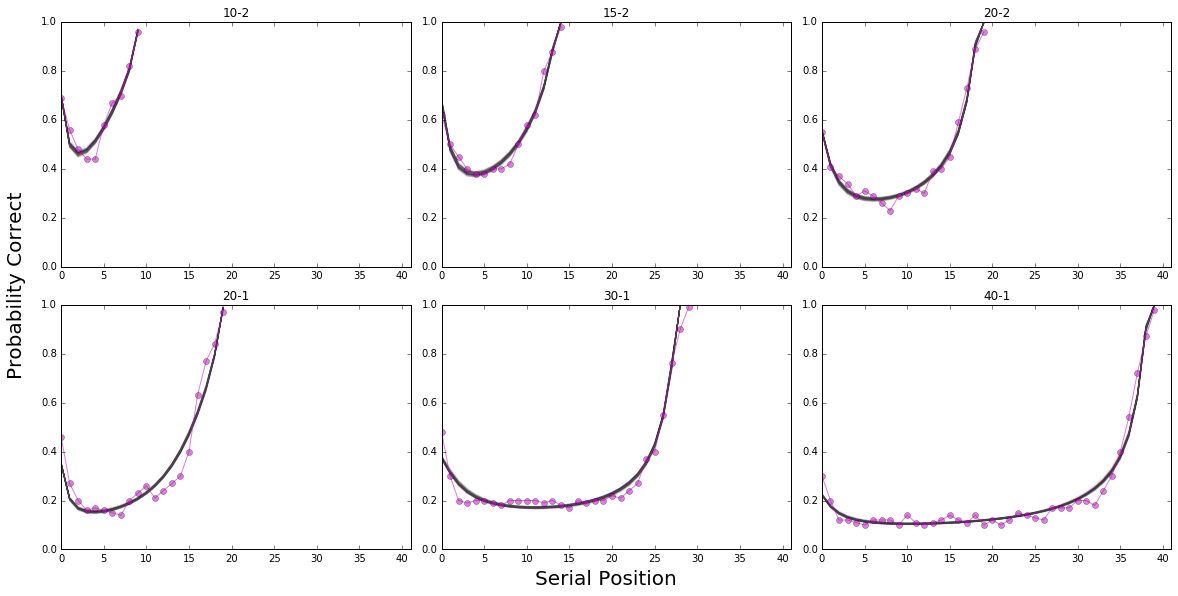

In [7]:
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Serial Position', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct', va='center', rotation='vertical',fontsize=20)

burnin=5000
totalsamp=3e5
ppcsamples=200

gs = gridspec.GridSpec(2,3)
for ip in range(dsets):
    ax = plt.subplot(gs[ip])
    ay=ymat[:,ip]/n[ip] # pcmat[:,ip]

    cxt=trace['cx'][:,ip]
    sxt=trace['sx'][:,ip]
    txt=trace['tx'][:,ip]
    
    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz,ip],]*sz).T
    m2 = np.array([mmat[0:sz,ip],]*sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):
        
        eta=np.exp(-cxt[ips]*abs(np.log(m1)-np.log(m2)))
        etasum=np.reshape(np.repeat(np.sum(eta,axis=1),sz),(sz,sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+np.exp(-sxt[ips]*(disc-txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp,axis=1),.999)
        ax.plot(theta,alpha=.05)
    
    ax.plot(ay[ay!=0],marker='o',alpha=.5)
    plt.axis((0,41,0,1))
    plt.title(str(listlength[ip])+'-'+str(lagall[ip]))

plt.tight_layout()
plt.show()

Similar to the model in STAN, the above model is also very sensitive to initial values. Train each dataset independently seems to resolve this issue. 

Applied interval-transform to cx and added transformed cx_interval to model.
Applied interval-transform to sx and added transformed sx_interval to model.
Applied interval-transform to tx and added transformed tx_interval to model.
 [-----------------100%-----------------] 30000 of 30000 complete in 10.5 secApplied interval-transform to cx and added transformed cx_interval to model.
Applied interval-transform to sx and added transformed sx_interval to model.
Applied interval-transform to tx and added transformed tx_interval to model.
 [-----------------100%-----------------] 30000 of 30000 complete in 9.4 secApplied interval-transform to cx and added transformed cx_interval to model.
Applied interval-transform to sx and added transformed sx_interval to model.
Applied interval-transform to tx and added transformed tx_interval to model.
 [-----------------100%-----------------] 30000 of 30000 complete in 10.0 secApplied interval-transform to cx and added transformed cx_interval to model.


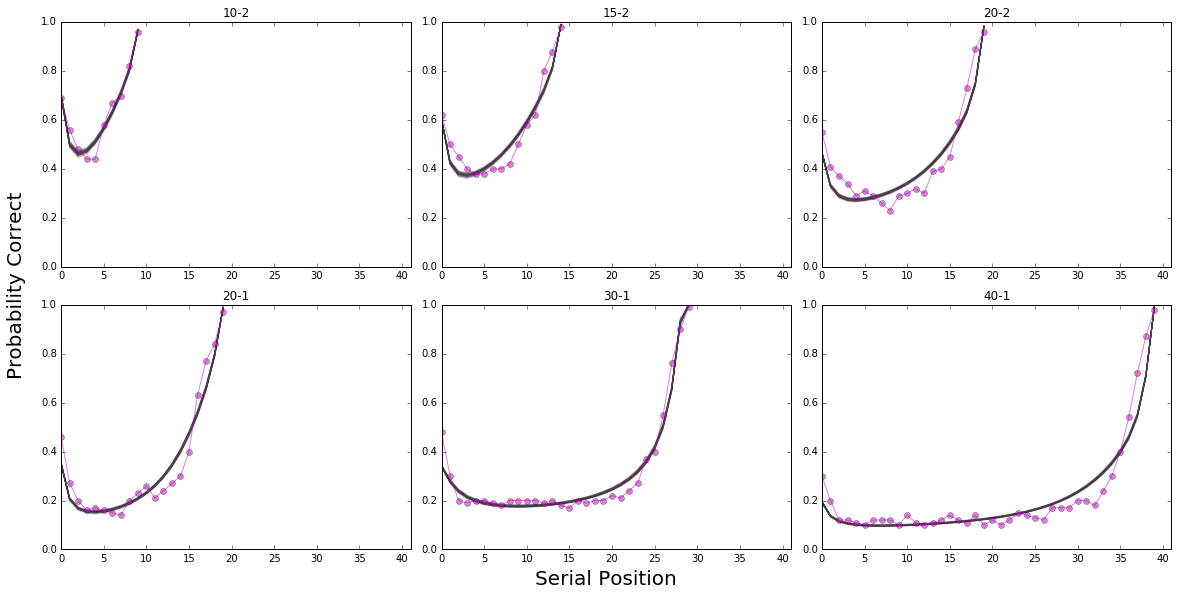

In [8]:
indiv_dset = {}
for x in range(dsets):
    sz = listlength[x]
    # Similarities
    m1 = np.array([mmat[0:sz,x],]*sz).T
    m2 = np.array([mmat[0:sz,x],]*sz)
    with pm.Model():
        cx = pm.Uniform("cx",lower=0,upper=100)
        sx = pm.Uniform("sx",lower=0,upper=100)
        tx = pm.Uniform("tx",lower=0,upper=1)
        
        eta=T.exp(-cx*abs(T.log(m1)-T.log(m2)))
        etasum=T.reshape(T.repeat(T.sum(eta,axis=1),sz),(sz,sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+T.exp(-sx*(disc-tx)))
        # Free Recall Overall Response Probability
        theta = T.clip(T.sum(resp,axis=1),0,.999)
        # theta=1-T.prod(1-resp,axis=1)

        yobs.append([pm.Binomial("yobs_%x"%x,p=theta, n=n[x],observed=ymat[0:sz,x])])
        # start = pm.find_MAP()
        # step = pm.NUTS(scaling=start)
        trace = pm.sample(3e4,step=pm.Metropolis())
    indiv_dset[x]=trace
    
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Serial Position', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct', va='center', rotation='vertical',fontsize=20)

burnin=5000
totalsamp=3e4
ppcsamples=200

gs = gridspec.GridSpec(2,3)
for ip in range(dsets):
    ax = plt.subplot(gs[ip])
    ay=ymat[:,ip]/n[ip] # pcmat[:,ip]
    
    cxt=indiv_dset[ip]['cx']
    sxt=indiv_dset[ip]['sx']
    txt=indiv_dset[ip]['tx']
    
    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz,ip],]*sz).T
    m2 = np.array([mmat[0:sz,ip],]*sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):
        
        eta=np.exp(-cxt[ips]*abs(np.log(m1)-np.log(m2)))
        etasum=np.reshape(np.repeat(np.sum(eta,axis=1),sz),(sz,sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+np.exp(-sxt[ips]*(disc-txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp,axis=1),.999)
        ax.plot(theta,alpha=.05)
    
    ax.plot(ay[ay!=0],marker='o',alpha=.5)
    plt.axis((0,41,0,1))
    plt.title(str(listlength[ip])+'-'+str(lagall[ip]))

plt.tight_layout()
plt.show()

## 15.2 A hierarchical extension of SIMPLE


$$ c \sim \text{Uniform}(0,100)$$
$$ s \sim \text{Uniform}(0,100)$$
$$ a_{1} \sim \text{Uniform}(-1,0) $$
$$ a_{2} \sim \text{Uniform}(0,1) $$
$$ t_x = a_{1}W_x + a_{2} $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

Applied interval-transform to cx and added transformed cx_interval to model.
Applied interval-transform to sx and added transformed sx_interval to model.
Applied interval-transform to a1 and added transformed a1_interval to model.
Applied interval-transform to a2 and added transformed a2_interval to model.
 [-----------------100%-----------------] 300000 of 300000 complete in 490.0 sec

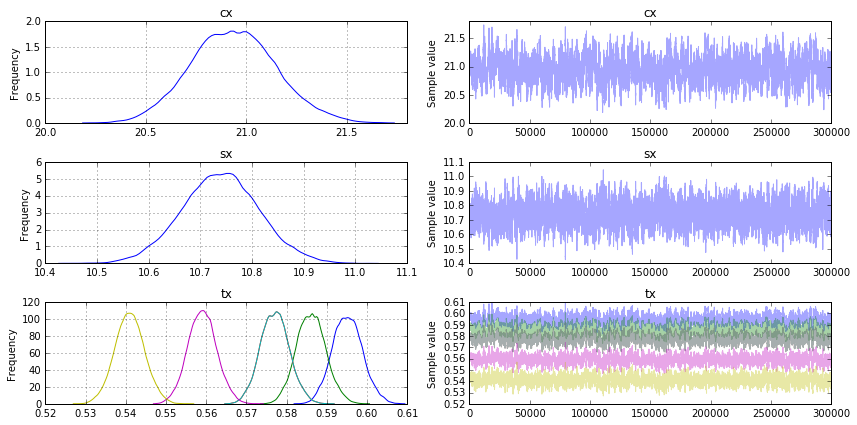

In [5]:
W = listlength
with pm.Model() as simple2:
    # This model is also sens
    cx = pm.Uniform("cx",lower=0,upper=100,testval=21)
    sx = pm.Uniform("sx",lower=0,upper=100,testval=10)
    a1 = pm.Uniform("a1",lower=-1,upper=0,testval=-.002)
    a2 = pm.Uniform("a2",lower=0,upper=1,testval=.64)
    tx = pm.Deterministic("tx",a1*W+a2)
    
    yobs=[]
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz,x],]*sz).T
        m2 = np.array([mmat[0:sz,x],]*sz)

        eta=T.exp(-cx*abs(T.log(m1)-T.log(m2)))
        etasum=T.reshape(T.repeat(T.sum(eta,axis=1),sz),(sz,sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+T.exp(-sx*(disc-tx[x])))
        # Free Recall Overall Response Probability
        theta = T.clip(T.sum(resp,axis=1),0,.999)
        # theta=1-T.prod(1-resp,axis=1)
        
        yobs.append([pm.Binomial("yobs_%x"%x,p=theta, n=n[x],observed=ymat[0:sz,x])])
        
    start = pm.find_MAP()
    # step = pm.NUTS(scaling=start)
    trace2 = pm.sample(3e5,start=start,step=pm.Metropolis())
    
pm.traceplot(trace2,varnames=['cx','sx','tx'])
plt.show()

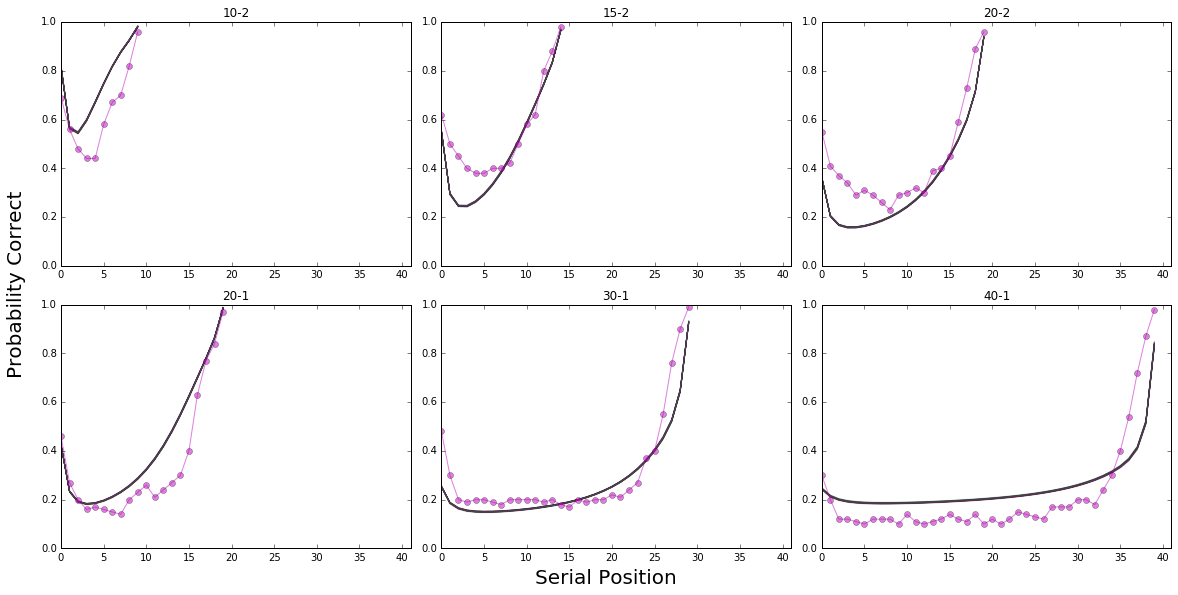

In [7]:
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Serial Position', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct', va='center', rotation='vertical',fontsize=20)

burnin=5000
totalsamp=3e5
ppcsamples=200

gs = gridspec.GridSpec(2,3)
for ip in range(dsets):
    ax = plt.subplot(gs[ip])
    ay=ymat[:,ip]/n[ip] # pcmat[:,ip]

    cxt=trace2['cx']
    sxt=trace2['sx']
    txt=trace2['tx'][:,ip]
    
    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz,ip],]*sz).T
    m2 = np.array([mmat[0:sz,ip],]*sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):
        
        eta=np.exp(-cxt[ips]*abs(np.log(m1)-np.log(m2)))
        etasum=np.reshape(np.repeat(np.sum(eta,axis=1),sz),(sz,sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+np.exp(-sxt[ips]*(disc-txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp,axis=1),.999)
        ax.plot(theta,alpha=.05)
    
    ax.plot(ay[ay!=0],marker='o',alpha=.5)
    plt.axis((0,41,0,1))
    plt.title(str(listlength[ip])+'-'+str(lagall[ip]))

plt.tight_layout()
plt.show()